# 1. Introduction
## 1.1. Background
In Kyoto, Japan, one of the biggest cultural events is viewing cherry blossoms. Every year, experts try to predict when the peak bloom (75% of all trees in bloom) will occur so people will be able to enjoy the amazing bloom at the right time.


## 1.2. Objectives
Predict the cherry blossom peak bloom day (DOY) at Japan/Kyoto in 2022-2026 years using a time series model. 

# 2. Methods
+ Exploratory Data Analysis (EDA)
+ Autoregressive Integrated Moving Average (ARIMA) Model
+ Model Selection with AIC and BIC
+ Model Diagnosis
+ Model Forcasting 

# 3. EDA

In [10]:
setwd('/Users/wushuangyan/Desktop/STAT classes/Finished/STAT 8000')

[1] "/Users/wushuangyan/Desktop/STAT classes/Finished/STAT 8000"

In [14]:
library(tidyverse)
library(ggplot2)
library(readxl)
library (ISLR)
library (splines )
library(dplyr)
library(astsa)

### Import Data

In [150]:
data <- read_excel("FullFlower.xls", sheet = 2, col_names = TRUE,na=c("","NA"))
data[1:2,]

Location,lat,long,alt,year,Fbloom_date,Fbloom_doy
Japan/Wakkanai,45.415,141.6789,2.85,1953,1953-05-30,150
Japan/Wakkanai,45.415,141.6789,2.85,1954,1954-05-27,147


In [410]:
# Rename for better reference
names(data)[c(5,7)] <- c("Year", "DOY") 

# DOY: day of the year for full bloom, e.g., 150: 150th day
head(data)
tail(data)

Location,lat,long,alt,Year,Fbloom_date,DOY
Japan/Wakkanai,45.415,141.6789,2.85,1953,1953-05-30,150
Japan/Wakkanai,45.415,141.6789,2.85,1954,1954-05-27,147
Japan/Wakkanai,45.415,141.6789,2.85,1955,1955-05-23,143
Japan/Wakkanai,45.415,141.6789,2.85,1956,1956-05-14,135
Japan/Wakkanai,45.415,141.6789,2.85,1957,1957-05-22,142
Japan/Wakkanai,45.415,141.6789,2.85,1958,1958-05-25,145


Location,lat,long,alt,Year,Fbloom_date,DOY
Japan/Ishigakijima,24.33667,124.1644,5.7,2015,2015-01-24,24
Japan/Ishigakijima,24.33667,124.1644,5.7,2016,2016-03-02,62
Japan/Ishigakijima,24.33667,124.1644,5.7,2017,2017-02-19,50
Japan/Ishigakijima,24.33667,124.1644,5.7,2018,2018-02-07,38
Japan/Ishigakijima,24.33667,124.1644,5.7,2019,2019-02-08,39
Japan/Ishigakijima,24.33667,124.1644,5.7,2021,2021-02-08,39


### Data Subset for Time Series Analysis

In [411]:

df <- data[data$Location == "Japan/Kyoto",c(1,5,7)] 
head(df)

print("Data dimension:")
dim(df)

Location,Year,DOY
Japan/Kyoto,1953,101
Japan/Kyoto,1954,95
Japan/Kyoto,1955,97
Japan/Kyoto,1956,101
Japan/Kyoto,1957,102
Japan/Kyoto,1958,98


[1] "Data dimension:"


[1] 69  3

### Data Summary

In [415]:
print("Data Summary:")
summary(df)

[1] "Data Summary:"


   Location              Year           DOY        
 Length:69          Min.   :1953   Min.   : 85.00  
 Class :character   1st Qu.:1970   1st Qu.: 93.00  
 Mode  :character   Median :1987   Median : 96.00  
                    Mean   :1987   Mean   : 96.12  
                    3rd Qu.:2004   3rd Qu.: 99.00  
                    Max.   :2021   Max.   :107.00  

### Plot Data

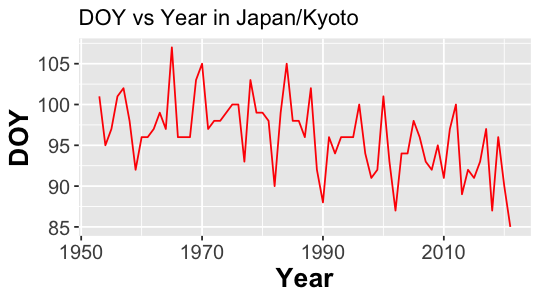

In [416]:
options(repr.plot.width = 4.5, repr.plot.height = 2.5)
ggplot(df, aes(x = Year, y = DOY)) +
geom_line(color = "red", size = 0.5)+
ggtitle ("DOY vs Year in Japan/Kyoto")+ 
theme (axis.text = element_text(size=12), 
       axis.title=element_text(size=16,face="bold"))

### Check Missing Data

In [417]:
pMiss <- function(x){
  sum(is.na(x))/length(x)*100
}
print("Missing data:")
(miss <- sort(apply(df,2,pMiss) ,decreasing =TRUE))

[1] "Missing data:"


Location     Year      DOY 
       0        0        0

# 4. Time Series - ARIMA Model

### Model Equation

The general model equation for ARMA model is shown below.

$$Y_t = \sum_{i=1}^{p}\phi_i Y_{t-i} + e_t - \sum_{j=1}^{q}\theta_je_{t-j}$$

Where $\phi_i$ are the autoregressive parameters, $\theta_j$ are the moving average parameters, and $e_t$ are unknown randon errors that follow Gaussian distribution (white noise).

### Plot Original and Differenced Data

[1] "Time Series of DOY:"


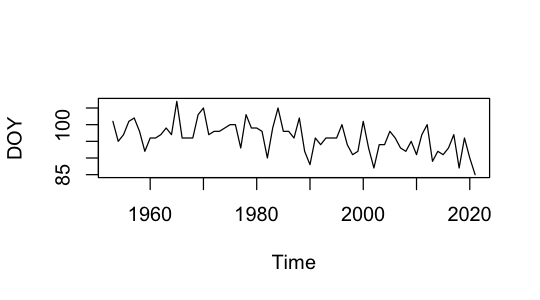

In [330]:
DOY <- ts(df$DOY, start = c(1953,1), frequency=1)
print("Time Series of DOY:")
plot.ts(DOY);

[1] "Yealy Change in DOY:"


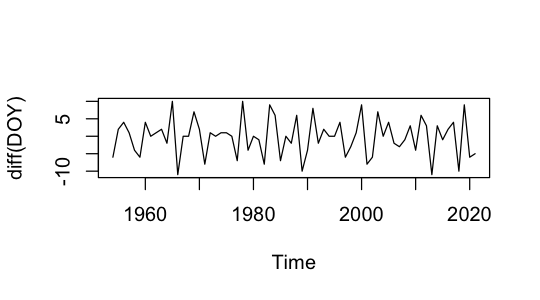

In [329]:
print("Yealy Change in DOY:")
plot.ts(diff(DOY))

From the first figure above, it is seen that the DOY bounces between 85 to 110, and the DOY time series is non-stationary with an overall decreasing trend. After first differencing (i.e. $Y_{diff}(t) = Y_t−Y_{t−1}$), the decreasing trend disappears, and the time series (second plot above) becomes steady and stationary, Since many time series analysis techniques rely on stationarity, the DOY time series data after differencing is used for further analysis.

### ACF and PACF

ACF,0.25,0.07,0.21,0.20,0.37,0.09,0.18,0.32,0.18,0.12,0.14,0.25,0.19,0.08,0.08,0.18,0.08,0.06,0.12
PACF,0.25,0.01,0.20,0.12,0.33,-0.10,0.18,0.14,0.05,-0.08,0.09,0.07,-0.01,-0.03,-0.03,0.03,-0.13,0.03,0.02


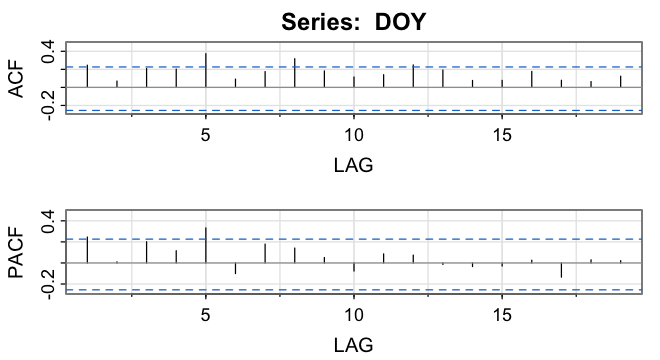

ACF,-0.37,-0.20,0.04,-0.07,0.31,-0.26,-0.05,0.18,0.01,-0.09,-0.09,0.11,0.05,-0.08,-0.05,0.13,-0.09,-0.03,0.08
PACF,-0.37,-0.38,-0.28,-0.37,0.09,-0.18,-0.16,-0.01,0.14,-0.04,-0.04,0.05,0.02,-0.05,-0.03,0.14,-0.11,-0.10,0.07


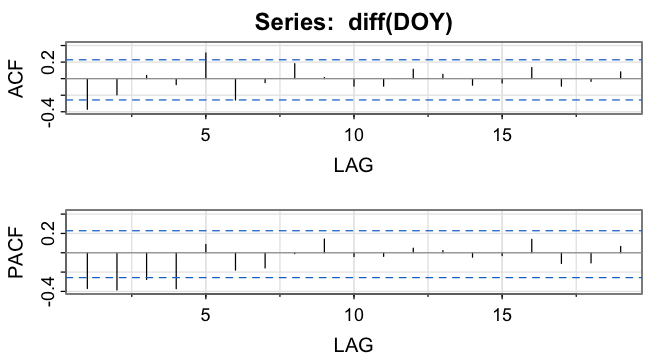

In [223]:
acf2(DOY)
acf2(diff(DOY))

The auto-correlation function (ACF) and partial auto-correlation function (PACF) of the original and differenced time series are checked as shown above. From the diff(DOY) plot, it is found that based on PACF and ACF, AR(2) and MA(1) may be a good choice for the parameters. In order to select the best p and q, the Akaike information criterion (AIC) and Bayesian information criterion (BIC) are also used for model selection.

# 5. Model Selection with AIC and BIC

In [419]:
AICtable = matrix(NA, 8, 8)
dimnames(AICtable) = list(paste("p =", 0:7), paste("q =", 0:7))
for (p in 0:7) {
  for (q in 0:7) {
    fit.arma = arima(diff(DOY), order=c(p,0,q),
                     optim.control = list(maxit = 1500))
    AICtable[p+1, q+1] = AIC(fit.arma)
} }

print("AIC Table:")
AICtable

[1] "AIC Table:"


,q = 0,q = 1,q = 2,q = 3,q = 4,q = 5,q = 6,q = 7
p = 0,422.7115,384.7757,386.6630,384.6483,386.0588,387.3299,384.2417,386.6088
p = 1,414.5279,386.7114,384.0204,385.2224,386.4410,387.5506,386.2160,386.8996
p = 2,404.4116,385.5461,387.4650,386.4931,388.0707,382.7297,382.1695,384.1169
p = 3,400.6799,387.6079,386.4430,388.0655,383.4486,382.8868,384.0531,386.0572
p = 4,388.7776,388.5749,386.5771,387.3295,382.0689,384.0570,385.9749,387.9631
p = 5,390.6669,386.6367,386.4408,387.8134,384.0547,386.0521,387.4833,389.2343
p = 6,388.3810,385.7668,387.7397,384.4160,385.0045,387.2509,386.5436,387.9389
p = 7,386.5880,387.7047,389.6369,384.7341,386.7334,389.0013,390.0508,390.2130


In [420]:
BICtable = matrix(NA, 8, 8)
dimnames(BICtable) = list(paste("p =", 0:7), paste("q =", 0:7))
for (p in 0:7) {
  for (q in 0:7) {
    fit.arma = arima(diff(DOY), order=c(p,0,q), 
                     optim.control = list(maxit = 1500))
    BICtable[p+1, q+1] = BIC(fit.arma)
} }

print("BIC Table:")
BICtable

[1] "BIC Table:"


,q = 0,q = 1,q = 2,q = 3,q = 4,q = 5,q = 6,q = 7
p = 0,427.1505,391.4342,395.5410,395.7458,399.3758,402.8665,401.9977,406.5844
p = 1,421.1864,395.5894,395.1180,398.5395,401.9776,405.3067,406.1916,409.0947
p = 2,413.2896,396.6437,400.7821,402.0297,405.8267,402.7053,404.3645,408.5314
p = 3,411.7775,400.9250,401.9796,405.8216,403.4242,405.0819,408.4677,412.6913
p = 4,402.0946,404.1115,404.3332,407.3051,404.2640,408.4716,412.6090,416.8167
p = 5,406.2035,404.3928,406.4164,410.0085,408.4693,412.6862,416.3369,420.3074
p = 6,406.1370,405.7424,409.9348,408.8306,411.6386,416.1045,417.6167,421.2315
p = 7,406.5636,409.8998,414.0515,411.3681,415.5870,420.0744,423.3434,425.7251


From both AIC and BIC tables, (1) p=0, q = 1 and (2) p=1, q= 2 lead to low AIC and BIC values with relatively simple models. Therefore, these two ARIMA models and the selected model (p=2, q =1) from ACF and PACF plots are compared below.

### Fit and Compare ARIMA Models

In [418]:
# Compare models
arima(DOY, order=c(0,1,1)) 
arima(DOY, order=c(1,1,2)) # optimal
arima(DOY, order=c(2,1,1))


Call:
arima(x = DOY, order = c(0, 1, 1))

Coefficients:
          ma1
      -0.8666
s.e.   0.0509

sigma^2 estimated as 16.23:  log likelihood = -191.94,  aic = 387.88


Call:
arima(x = DOY, order = c(1, 1, 2))

Coefficients:
          ar1     ma1      ma2
      -0.8277  0.1263  -0.8737
s.e.   0.0731  0.1259   0.1125

sigma^2 estimated as 14.75:  log likelihood = -189.64,  aic = 387.27


Call:
arima(x = DOY, order = c(2, 1, 1))

Coefficients:
          ar1      ar2      ma1
      -0.0390  -0.2673  -0.8189
s.e.   0.1312   0.1268   0.0715

sigma^2 estimated as 15.22:  log likelihood = -189.88,  aic = 387.75

The ARIMA(1,1,2) model shows better comprehensive performance than other two models with lower $\sigma^2$ and AIC, and higher log likelihood, therefore is selected for model forcasting.

# 6. Model Diagnosis

initial  value 1.658583 
iter   2 value 1.450925
iter   3 value 1.401765
iter   4 value 1.392396
iter   5 value 1.392046
iter   6 value 1.390587
iter   7 value 1.389471
iter   8 value 1.377573
iter   9 value 1.373554
iter  10 value 1.372747
iter  11 value 1.371336
iter  12 value 1.370975
iter  13 value 1.370908
iter  14 value 1.370874
iter  15 value 1.370874
iter  15 value 1.370874
final  value 1.370874 
converged
initial  value 1.375848 
iter   2 value 1.375536
iter   3 value 1.374886
iter   4 value 1.371715
iter   5 value 1.370667
iter   6 value 1.370362
iter   7 value 1.370201
iter   8 value 1.369850
iter   9 value 1.369847
iter  10 value 1.369844
iter  11 value 1.369843
iter  12 value 1.369843
iter  13 value 1.369843
iter  13 value 1.369843
iter  13 value 1.369843
final  value 1.369843 
converged


$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    include.mean = !no.constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
          ar1     ma1      ma2
      -0.8277  0.1263  -0.8737
s.e.   0.0731  0.1259   0.1125

sigma^2 estimated as 14.75:  log likelihood = -189.64,  aic = 387.27

$degrees_of_freedom
[1] 65

$ttable
    Estimate     SE  t.value p.value
ar1  -0.8277 0.0731 -11.3268  0.0000
ma1   0.1263 0.1259   1.0030  0.3196
ma2  -0.8737 0.1125  -7.7641  0.0000

$AIC
[1] 5.69521

$AICc
[1] 5.700725

$BIC
[1] 5.825769


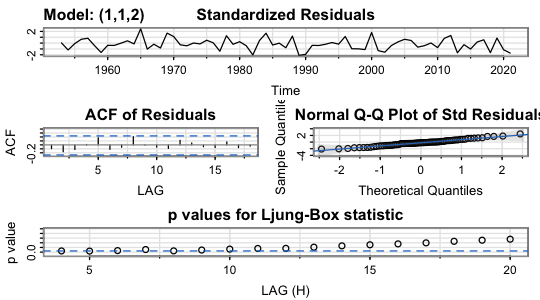

In [425]:
(model <- sarima(DOY, 1, 1, 2, no.constant=TRUE))

The original data shows a decreasing trend, therefore, 1 differencing is to applied to get stationary data. Then a ARIMA(1,1,2) model is fitted with the data, with which, the model AIC = 5.65, AICc = 5.66, and BIC = 5.81. The model fits well as seen from the residual plots above. The standardized residual plot shows no significant trend or inconsistent variance. The Q-Q plot follows an approximately straight line indicating the residuals are normally distrubuted. These plots suggest the ARIMA(1,1,2) model has adequately captured the information in the data. 

# 7. Model Forecasting

### DOY for 2022-2026 Years

Prediced
92.18
91.87
91.92
91.67
91.66


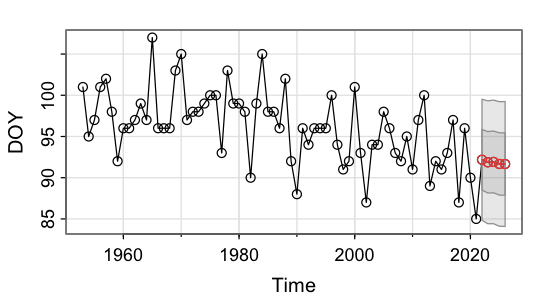

In [426]:
fit <- sarima.for(DOY, 5, 1, 1, 2)
data.frame(Prediced = round(fit$pred, 2))

### Standard Error

In [369]:
# SE for the prediction for 2022-2026 years
data.frame(SE = round(fit$se, 2))

SE
3.67
3.73
3.75
3.78
3.79


# 8. Summary

The 5-year DOY prediction with 1*SE and 2*SE can be seen in the forcasting plot above. The predicted values for the next 5 years show a slight decrease. The predicted full bloom day in Japan/Kyoto for 2022 is 92.18 (SE = 3.67 days), it is close to the true DOY = 93 [1]. And the final ARIMA (1,1,2) model equation is shown below.
$$z_t = -0.8277*z_{t-1} + e_ t - 0.1263*e_{t-1} +0.8737*e_{t-2}$$
Where$$z_t = y_t - y_{t-1}$$

# Reference

1. https://www.metoffice.gov.uk/about-us/press-office/news/weather-and-climate/2022/kyoto-cherry-blossom-dates-shifted-by-human-influence#:~:text=Last%20year%20was%20the%20earliest,declared%20on%201%20April%202022.